# Model Analysis

Analyze vanilla model to understand causes of variability in the predicted value

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy import stats
from statsmodels.formula.api import ols

# Data Edit 1. Gender Reclassified

Gender reclassified using U.S. Social Security name data from 1918~2018.
Over 80% of male/female gender is classfied as male/female. Under 80% is classified as neutral. 

_Note: 80% threshold editable_

In [14]:
df = pd.read_csv('finalclean.csv')

In [15]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'userName', 'splitName', 'comment',
       'n_recommend', 'n_reply', 'nyt_select', 'recommendflag', 'url',
       'ttlCommentNum', 'gender', 'time', 'time_order', 'tech', 'Name',
       'gender_', 'gender__', 'n_rec_log'],
      dtype='object')

In [16]:
df= df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'gender', 'gender_', 'gender__'], axis = 1)

In [17]:
df.head()

,userName,splitName,comment,n_recommend,n_reply,nyt_select,recommendflag,url,ttlCommentNum,time,time_order,tech,Name,n_rec_log
0,AB,AB,This is when it hurts us not having a competen...,1046,7,False,0,https://www.nytimes.com/2020/03/09/business/st...,1486,2020-03-09 06:46:01,1,True,ab,6.953684
1,Mark,Mark,Our illustrious commander-in-chief was all too...,1183,17,False,0,https://www.nytimes.com/2020/03/09/business/st...,1486,2020-03-09 06:58:13,2,True,mark,7.076654
2,Nomind7,Nomind,This is when it hurts us not having universal ...,1046,33,False,0,https://www.nytimes.com/2020/03/09/business/st...,1486,2020-03-09 06:59:10,3,True,nomind,6.953684
3,Michael,Michael,Oil prices falling is a symptom of demand fall...,136,4,False,0,https://www.nytimes.com/2020/03/09/business/st...,1486,2020-03-09 07:19:59,4,True,michael,4.919981
4,Larry,Larry,Virus at my daughters school in Boston. I have...,68,2,False,0,https://www.nytimes.com/2020/03/09/business/st...,1486,2020-03-09 07:29:30,5,True,larry,4.234107


In [18]:
# Clip it so that time order no longer affects after first 25 scrolls

df['time_order_cap'] = df['time_order'].clip(1,25)

In [43]:
male_names = pd.read_csv('male_names.csv', header = None)
import numpy as np
male_names = np.asarray(male_names)
male_names = np.concatenate(male_names).ravel().tolist()
male_names = [name.lower() for name in male_names]

female_names = pd.read_csv('female_names.csv', header = None)
female_names = np.asarray(female_names)
female_names = np.concatenate(female_names).ravel().tolist()
female_names = [name.lower() for name in female_names]

neutral_names = pd.read_csv('neutral_names.csv', header = None)
neutral_names = np.asarray(neutral_names)
neutral_names = np.concatenate(neutral_names).ravel().tolist()
neutral_names = [name.lower() for name in neutral_names]

In [44]:
df['gender'] = np.repeat(None, len(df))

for v in range(0, len(df)):
# Clean the name structure
    if df['Name'].iloc[v] in neutral_names:
        df.loc[v, 'gender'] = 2
    elif df['Name'].iloc[v] in male_names:
        df.loc[v, 'gender'] = 0
    elif df['Name'].iloc[v] in female_names:
        df.loc[v, 'gender'] = 1
    else:
        df.loc[v, 'gender'] = 2

In [45]:
df.groupby(['gender']).size()

gender
0    1193
1     513
2    1239
dtype: int64

# Data Edit 2: ttlCommentNum logged

In [46]:
df['ttl_comment_log'] = np.log(np.asarray(df['ttlCommentNum'])+1)

# Model Analysis: Explain Variability

In [49]:
model1 = ols('n_rec_log ~ C(gender) + C(nyt_select) + ttl_comment_log + time_order_cap', data = df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     569.8
Date:                Tue, 14 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:58:12   Log-Likelihood:                -3995.5
No. Observations:                2945   AIC:                             8003.
Df Residuals:                    2939   BIC:                             8039.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.04

In [50]:
df['yhat_model1'] = model.fittedvalues
df['residual_model1'] = df['n_rec_log'] - model.fittedvalues

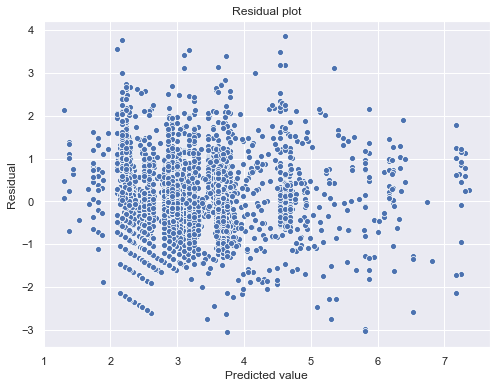

In [59]:
# Simple residual plot
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x='yhat_model1', y='residual_model1', data=df)
_ = plt.xlabel('Predicted value')
_ = plt.ylabel('Residual')
_ = plt.title('Residual plot')

Text(0.5, 1.0, 'Residuals, by Gender')

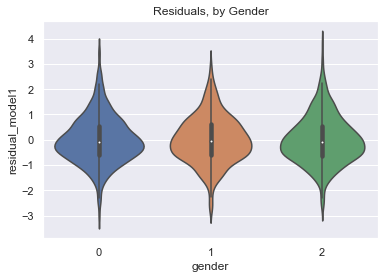

In [112]:
# Violin plot on residuals based on gender. 
# 0 = Male, 1 = Female, 2 = Unknown
sns.violinplot(x = 'gender', y = 'residual_model1', data = df)
plt.title('Residuals, by Gender')

In [65]:
# Select ones with absolute residual values greater than 2 and analyze them
big_df = df[(df['residual_model1']>=2) | (df['residual_model1']<=-2)]

In [66]:
big_df.describe()

,n_recommend,n_reply,recommendflag,ttlCommentNum,time_order,n_rec_log,time_order_cap,gender,ttl_comment_log,yhat_model1,residual_model1
count,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,421.076336,4.351145,0.0,989.389313,58.564885,4.271974,21.664122,1.007634,6.247967,3.301719,0.970254
std,776.822479,9.681007,0.0,1308.634471,44.967698,2.507162,6.650171,0.924006,1.084304,1.140091,2.299128
min,0.000000,0.000000,0.0,63.000000,1.000000,0.000000,1.000000,0.000000,4.158883,1.304955,-3.053206
25%,12.500000,0.000000,0.0,206.000000,23.500000,2.602003,23.500000,0.000000,5.332719,2.283421,-2.210904
50%,127.000000,1.000000,0.0,306.000000,42.000000,4.852030,25.000000,1.000000,5.726848,3.099389,2.128407
75%,494.000000,5.000000,0.0,1259.000000,100.500000,6.204458,25.000000,2.000000,7.138867,3.949609,2.524945
max,4792.000000,88.000000,0.0,4408.000000,159.000000,8.474912,25.000000,2.000000,8.391403,7.173478,3.856801


In [67]:
df.describe()

,n_recommend,n_reply,recommendflag,ttlCommentNum,time_order,n_rec_log,time_order_cap,gender,ttl_comment_log,yhat_model1,residual_model1
count,2945.000000,2945.000000,2945.0,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2.945000e+03
mean,93.075042,1.608149,0.0,855.726995,79.882513,3.265875,22.962649,1.015620,6.329923,3.265875,-3.481840e-16
std,362.251236,4.749635,0.0,983.257453,48.896169,1.318938,5.397762,0.908759,0.885357,0.925366,9.398382e-01
min,0.000000,0.000000,0.0,63.000000,1.000000,0.000000,1.000000,0.000000,4.158883,1.304955,-3.053206e+00
25%,10.000000,0.000000,0.0,293.000000,37.000000,2.397895,25.000000,0.000000,5.683580,2.577276,-6.110409e-01
50%,21.000000,0.000000,0.0,520.000000,77.000000,3.091042,25.000000,1.000000,6.255750,3.099389,-8.619665e-02
75%,51.000000,1.000000,0.0,1078.000000,119.000000,3.951244,25.000000,2.000000,6.983790,3.687405,5.582178e-01
max,7799.000000,99.000000,0.0,4408.000000,175.000000,8.961879,25.000000,2.000000,8.391403,7.367177,3.856801e+00


Note: 

The ones with big variability have more recommendations (average recommendation is 93 vs 421) and number of replies. There are more than gender(`gender`), time order(`time_order_cap`), nyt endorsement(`nyt_select`), article popularity(`ttl_comment_log`). These ones are recommended regardless. 

* Because of article characteristic (topicality)?
-> Tech /non tech; color by url

* Quality of comments matter?
-> Add word count and compare that.

### Residual explain 1) Article differences?

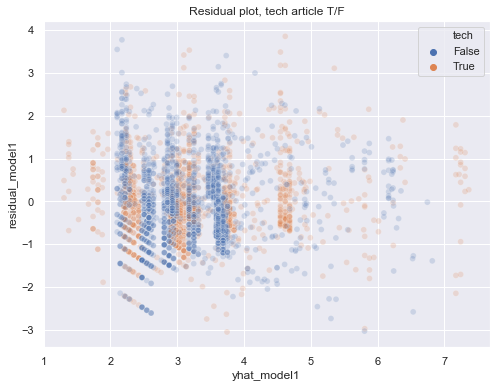

In [68]:
# Residual plot with "tech article YES/NO"

sns.set()
fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x = 'yhat_model1', y = 'residual_model1', data = df, hue = 'tech', alpha = 0.2)
_ = plt.title('Residual plot, tech article T/F')

There is a distinct clustering by tech/non-tech, the colors show it. There might be some differences by article type itself, that has more explanation than just the total number of comments in a particular article (i.e. article popularity)

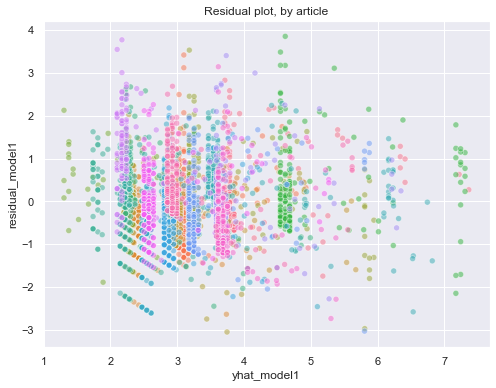

In [83]:
# Residual plot with "by article"

fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x = 'yhat_model1', y = 'residual_model1', data = df, hue = 'url', alpha = 0.5)
_ = plt.title('Residual plot, by article')
_ = ax.get_legend().set_visible(False)

The residual plot pattern reveals that there are lines, and each article "expands". It is not the particular article itself that causes this action, but another unknown value. What causes these particular comments to get "more" recommendations above others?

### Residual explain 2) Comment quality?

In [87]:
def word_count(string):
    tmp = str.split(string)
    return(len(tmp))

In [88]:
word_count("apple had tim cook")

4

In [107]:
df['wordcount'] = np.repeat(None, len(df))

for v in range(0, len(df)):
    tmp_string = df['comment'][v]
    tmp_count = word_count(tmp_string)
    df['wordcount'][v] = tmp_count
    
df['wordcount'] = df['wordcount'].astype('int')

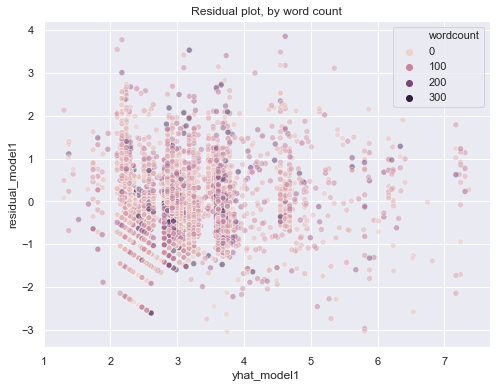

In [108]:
# Residual plot with "by word count"

fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x = 'yhat_model1', y = 'residual_model1', data = df, hue = 'wordcount', alpha = 0.5)
_ = plt.title('Residual plot, by word count')

This doesn't seem particularly promising... The word count doesn't matter. They are all scattered around. Would I need to add some interaction / quadratics to the model?

Before doing that, just compare if gender has any impact. Just in case.

### Residual explain 3) Gender?

In [109]:
# Select ones with absolute residual values greater than 2 and analyze them
big_df = df[(df['residual_model1']>=2) | (df['residual_model1']<=-2)]

In [110]:
big_df.describe()

,n_recommend,n_reply,recommendflag,ttlCommentNum,time_order,n_rec_log,time_order_cap,gender,ttl_comment_log,yhat_model1,residual_model1,wordcount
count,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,421.076336,4.351145,0.0,989.389313,58.564885,4.271974,21.664122,1.007634,6.247967,3.301719,0.970254,80.893130
std,776.822479,9.681007,0.0,1308.634471,44.967698,2.507162,6.650171,0.924006,1.084304,1.140091,2.299128,66.063169
min,0.000000,0.000000,0.0,63.000000,1.000000,0.000000,1.000000,0.000000,4.158883,1.304955,-3.053206,1.000000
25%,12.500000,0.000000,0.0,206.000000,23.500000,2.602003,23.500000,0.000000,5.332719,2.283421,-2.210904,32.000000
50%,127.000000,1.000000,0.0,306.000000,42.000000,4.852030,25.000000,1.000000,5.726848,3.099389,2.128407,63.000000
75%,494.000000,5.000000,0.0,1259.000000,100.500000,6.204458,25.000000,2.000000,7.138867,3.949609,2.524945,104.500000
max,4792.000000,88.000000,0.0,4408.000000,159.000000,8.474912,25.000000,2.000000,8.391403,7.173478,3.856801,266.000000


In [102]:
big_df.groupby(['gender']).size() # Gender proportion is the same. Above, with all, 17% female. This case, 15% female.

gender
0    55
1    20
2    56
dtype: int64

In [111]:
df.describe()

,n_recommend,n_reply,recommendflag,ttlCommentNum,time_order,n_rec_log,time_order_cap,gender,ttl_comment_log,yhat_model1,residual_model1,wordcount
count,2945.000000,2945.000000,2945.0,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2.945000e+03,2945.000000
mean,93.075042,1.608149,0.0,855.726995,79.882513,3.265875,22.962649,1.015620,6.329923,3.265875,-3.481840e-16,75.724958
std,362.251236,4.749635,0.0,983.257453,48.896169,1.318938,5.397762,0.908759,0.885357,0.925366,9.398382e-01,58.760739
min,0.000000,0.000000,0.0,63.000000,1.000000,0.000000,1.000000,0.000000,4.158883,1.304955,-3.053206e+00,1.000000
25%,10.000000,0.000000,0.0,293.000000,37.000000,2.397895,25.000000,0.000000,5.683580,2.577276,-6.110409e-01,32.000000
50%,21.000000,0.000000,0.0,520.000000,77.000000,3.091042,25.000000,1.000000,6.255750,3.099389,-8.619665e-02,60.000000
75%,51.000000,1.000000,0.0,1078.000000,119.000000,3.951244,25.000000,2.000000,6.983790,3.687405,5.582178e-01,103.000000
max,7799.000000,99.000000,0.0,4408.000000,175.000000,8.961879,25.000000,2.000000,8.391403,7.367177,3.856801e+00,285.000000


Doesn't seem like that those with big residual differences have differences in word count. Gender is not much of a difference either. Try different model with interaction and check that.

### Model 1: Some extra plots 

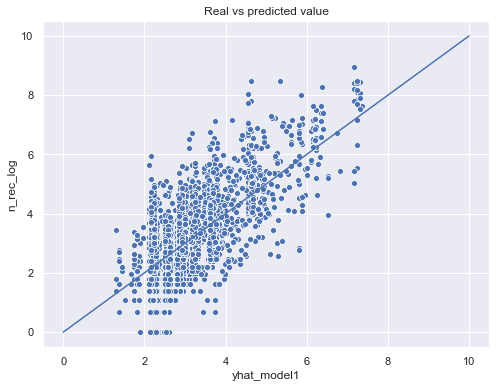

In [120]:
sns.set()

fig, ax = plt.subplots(figsize=(8,6))
_ = sns.scatterplot(x = 'yhat_model1', y = 'n_rec_log', data = df)
x = np.linspace(0, 10, 1000)
_ = plt.plot(x, x + 0, linestyle='solid')
_ = plt.title("Real vs predicted value")

In [51]:
from statsmodels.compat import lzip
import statsmodels.api as sm

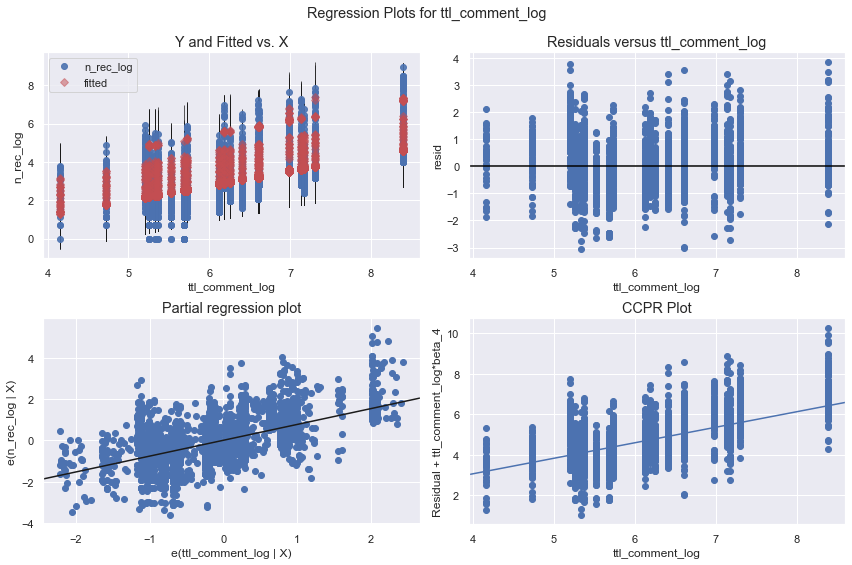

In [121]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model1, "ttl_comment_log", fig=fig)

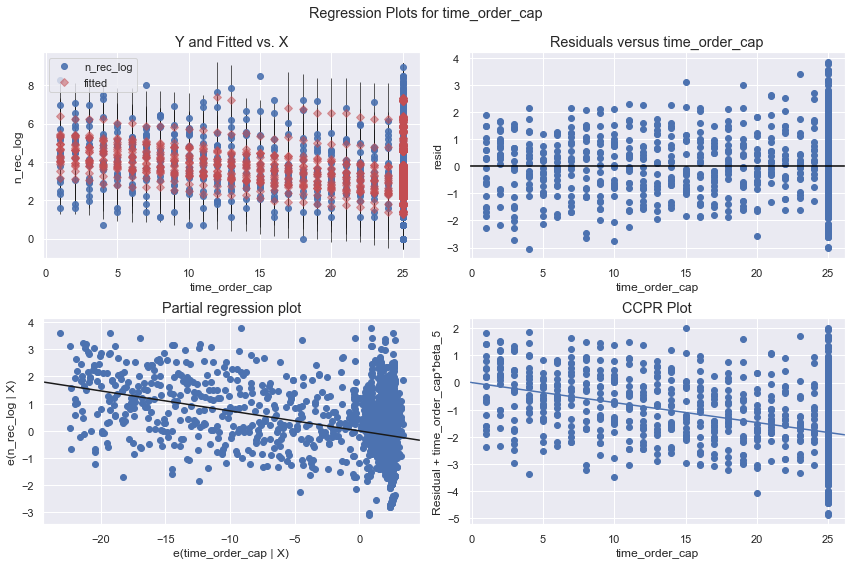

In [114]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "time_order_cap", fig=fig)

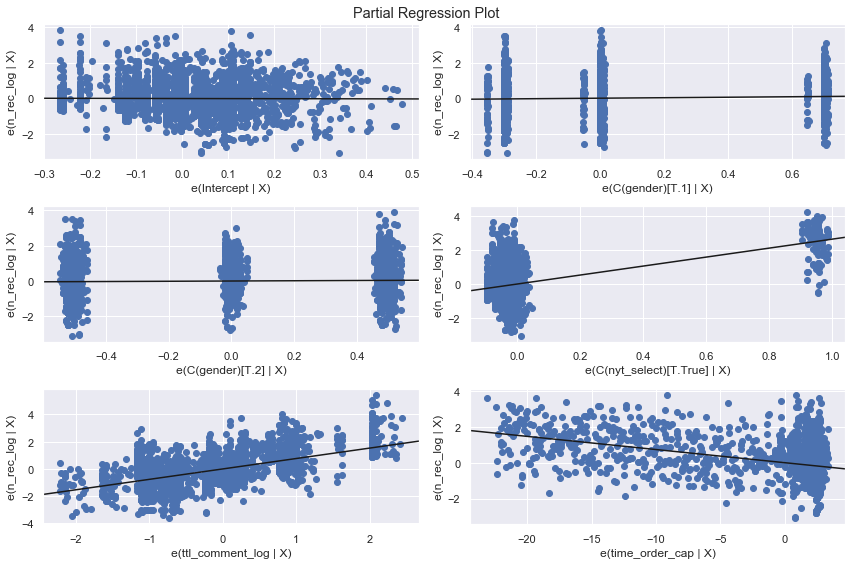

In [115]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model1, fig=fig)

# Which Variable Explains the Most?

In [125]:
print(ols('n_rec_log ~ C(gender)', data = df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.388
Date:                Tue, 14 Apr 2020   Prob (F-statistic):             0.0339
Time:                        12:45:23   Log-Likelihood:                -4990.1
No. Observations:                2945   AIC:                             9986.
Df Residuals:                    2942   BIC:                         1.000e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2325      0.038     84.

In [126]:
print(ols('n_rec_log ~ C(nyt_select)', data = df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     591.7
Date:                Tue, 14 Apr 2020   Prob (F-statistic):          2.99e-119
Time:                        12:45:41   Log-Likelihood:                -4723.8
No. Observations:                2945   AIC:                             9452.
Df Residuals:                    2943   BIC:                             9463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.16

In [127]:
print(ols('n_rec_log ~ ttl_comment_log', data = df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1112.
Date:                Tue, 14 Apr 2020   Prob (F-statistic):          4.50e-207
Time:                        12:45:53   Log-Likelihood:                -4521.7
No. Observations:                2945   AIC:                             9047.
Df Residuals:                    2943   BIC:                             9059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.6718      0.150    -

In [128]:
print(ols('n_rec_log ~ time_order_cap', data = df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              n_rec_log   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     167.5
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           2.60e-37
Time:                        12:46:04   Log-Likelihood:                -4912.0
No. Observations:                2945   AIC:                             9828.
Df Residuals:                    2943   BIC:                             9840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.5681      0.103     44.

|Gender|NYT Selection| Total Comments (logged)| Time Order (capped) |
|:----:|:----:|:----:|:----:|
|0.002 | 0.167 | 0.274 | 0.054

In [129]:
0.002 + 0.167 + 0.274 + 0.054

0.49700000000000005

Biggest weight is on total comments, followed by NYT endorsement.The four variables are not much correlated with each other. The $R^2$ sum is not that different.